# Music genre prediction

**Описание задачи**

Вы сотрудник Отдела Data Science популярного музыкального стримингового сервиса. Сервис расширяет работу с новыми артистами и музыкантами, в связи с чем возникла задача -- правильно классифицировать новые музыкальные треки, чтобы улучшить работу рекомендательной системы. Ваши коллеги из отдела работы со звуком подготовили датасет, в котором собраны некоторые характеристики музыкальных произведений и их жанры. Ваша задача - разработать модель, позволяющую классифицировать музыкальные произведения по жанрам.

В ходе работы пройдите все основные этапы полноценного исследования:

*  загрузка и ознакомление с данными
*  предварительная обработка
*  полноценный разведочный анализ
*  разработка новых синтетических признаков
*  проверка на мультиколлинеарность
*  отбор финального набора обучающих признаков
*  выбор и обучение моделей
*  итоговая оценка качества предсказания лучшей модели
*  анализ важности ее признаков

**ВАЖНО**  
Необходимо реализовать решение с использованием технологии `pipeline` (из библиотеки `sklearn`)

**ОЖИДАЕМЫЙ РЕЗУЛЬТАТ**

* Оформленный репозиторий на GitHub (ноутбук с исследованием + код приложения)
* Развернутое web-приложение (с использованием библиотеки Streamlit)

## Участники проекта, репозиторий, приложение

...

...

## Импорт библиотек, установка констант

In [1]:
%%capture
%pip install catboost -q

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pygwalker as pyg
import numpy as np


from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, r2_score
from catboost import CatBoostClassifier

In [3]:
TRAIN = "https://www.dropbox.com/scl/fi/5zy935lqpaqr9lat76ung/music_genre_train.csv?rlkey=ccovu9ml8pfi9whk1ba26zdda&dl=1"
TEST = "https://www.dropbox.com/scl/fi/o6mvsowpp9r3k2lejuegt/music_genre_test.csv?rlkey=ac14ydue0rzlh880jwj3ebum4&dl=1"

In [4]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

## Загрузка и обзор данных

In [5]:
train = pd.read_csv(TRAIN)
test = pd.read_csv(TEST)

In [6]:
train.sample(5)

instance_id               track_name  acousticness  danceability  \
8156       36128.0  Sure Be Cool If You Did        0.2550         0.576   
18958      89016.0             Silent Sword        0.0428         0.595   
5400       30433.0       Workin' Man's Ph.D        0.4360         0.699   
15253      26719.0                    ブラザーズ        0.0753         0.666   
12378      50243.0       Let's Build A Home        0.1200         0.263   

       duration_ms  energy  instrumentalness key  liveness  loudness   mode  \
8156      215720.0   0.726          0.000000   B    0.1080    -4.625  Major   
18958     248840.0   0.949          0.000000   F    0.3530    -3.355  Minor   
5400      210067.0   0.783          0.000167   C    0.2560    -9.490  Major   
15253         -1.0   0.886          0.000000   A    0.0501    -4.111  Minor   
12378     118400.0   0.916          0.000841   D    0.3230    -8.756  Major   

       speechiness    tempo obtained_date  valence music_genre  
8156        0.0350  136.802         4-Apr    0.582     Country  
18958       0.0512  145.955         4-Apr    0.627       Anime  
5400        0.0321  123.404         4-Apr    0.813     Country  
15253       0.0527  164.083         4-Apr    0.976       Anime  
12378       0.4040  166.906         4-Apr    0.248       Blues

**Описание полей данных**

`instance_id` - уникальный идентификатор трека  
`track_name` - название трека  
`acousticness` - акустичность  
`danceability` - танцевальность  
`duration_ms` -продолжительность в милисекундах  
`energy` - энергичность  
`instrumentalness` - инструментальность  
`key` - тональность  
`liveness` - привлекательность  
`loudness` - громкость  
`mode` - наклонение  
`speechiness` - выразительность  
`tempo` - темп  
`obtained_date` - дата загрузки в сервис  
`valence` - привлекательность произведения для пользователей сервиса  
`music_genre` - музыкальный жанр

## Предварительная обработка данных

In [7]:
print('Train data shape:', train.shape)
print('Test data shape:', test.shape)

Train data shape: (20394, 16)
Test data shape: (5099, 15)


*Отметим отсутствие в тестовой выборке одного столбца (предположительно - целевого*

In [8]:
test.sample(5)

instance_id                                         track_name  \
531         67338                                     Red Cold River   
1102        78594                            Young Girl Sunday Blues   
1130        70517                                     Polyushko-pole   
2948        35781  Die Zauberflöte, K. 620: Der Hölle Rache kocht...   
380         23005                          Blow Up The Outside World   

      acousticness  danceability  duration_ms  energy  instrumentalness key  \
531       0.000248         0.376     200907.0   0.967          0.000003  D#   
1102      0.190000         0.535     212907.0   0.501          0.000372   C   
1130      0.001260         0.542     266493.0   0.848          0.004940   E   
2948      0.980000         0.422     199400.0   0.180          0.358000   F   
380       0.000807         0.330     345667.0   0.529          0.214000   A   

      liveness  loudness   mode  speechiness    tempo obtained_date  valence  
531     0.0575    -3.277  Minor       0.1660   91.582         4-Apr    0.226  
1102    0.0379   -11.522  Major       0.0403  126.031         4-Apr    0.643  
1130    0.3130    -7.924  Minor       0.0296  139.969         4-Apr    0.696  
2948    0.6850   -19.507  Major       0.0695  138.764         4-Apr    0.234  
380     0.1260   -10.043  Major       0.0358  140.156         4-Apr    0.148

In [9]:
train.columns, test.columns

(Index(['instance_id', 'track_name', 'acousticness', 'danceability',
        'duration_ms', 'energy', 'instrumentalness', 'key', 'liveness',
        'loudness', 'mode', 'speechiness', 'tempo', 'obtained_date', 'valence',
        'music_genre'],
       dtype='object'),
 Index(['instance_id', 'track_name', 'acousticness', 'danceability',
        'duration_ms', 'energy', 'instrumentalness', 'key', 'liveness',
        'loudness', 'mode', 'speechiness', 'tempo', 'obtained_date', 'valence'],
       dtype='object'))

*В тестовой выборке отсутствует целевая переменная. Это значит, что в ходе работы мы будем работать только с тренировочной выборкой (и делить ее на трейн и тест), а для тестовой только получим предстказание*

In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20394 entries, 0 to 20393
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   instance_id       20394 non-null  float64
 1   track_name        20394 non-null  object 
 2   acousticness      20394 non-null  float64
 3   danceability      20394 non-null  float64
 4   duration_ms       20394 non-null  float64
 5   energy            20394 non-null  float64
 6   instrumentalness  20394 non-null  float64
 7   key               19659 non-null  object 
 8   liveness          20394 non-null  float64
 9   loudness          20394 non-null  float64
 10  mode              19888 non-null  object 
 11  speechiness       20394 non-null  float64
 12  tempo             19952 non-null  float64
 13  obtained_date     20394 non-null  object 
 14  valence           20394 non-null  float64
 15  music_genre       20394 non-null  object 
dtypes: float64(11), object(5)
memory usage: 

*Тренировочный датасет содержит пропуски в столбцах ``key``, ``mode``, ``tempo``. взглянем на тестовый датасет и решим, как с ними поступить*

In [11]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5099 entries, 0 to 5098
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   instance_id       5099 non-null   int64  
 1   track_name        5099 non-null   object 
 2   acousticness      5099 non-null   float64
 3   danceability      5099 non-null   float64
 4   duration_ms       5099 non-null   float64
 5   energy            5099 non-null   float64
 6   instrumentalness  5099 non-null   float64
 7   key               4941 non-null   object 
 8   liveness          5099 non-null   float64
 9   loudness          5099 non-null   float64
 10  mode              4950 non-null   object 
 11  speechiness       5099 non-null   float64
 12  tempo             4978 non-null   float64
 13  obtained_date     5099 non-null   object 
 14  valence           5099 non-null   float64
dtypes: float64(10), int64(1), object(4)
memory usage: 597.7+ KB


*Видим пропуски в тех же столбцах, следовательно, будем закладывать обработку пропусков в пайплайн*

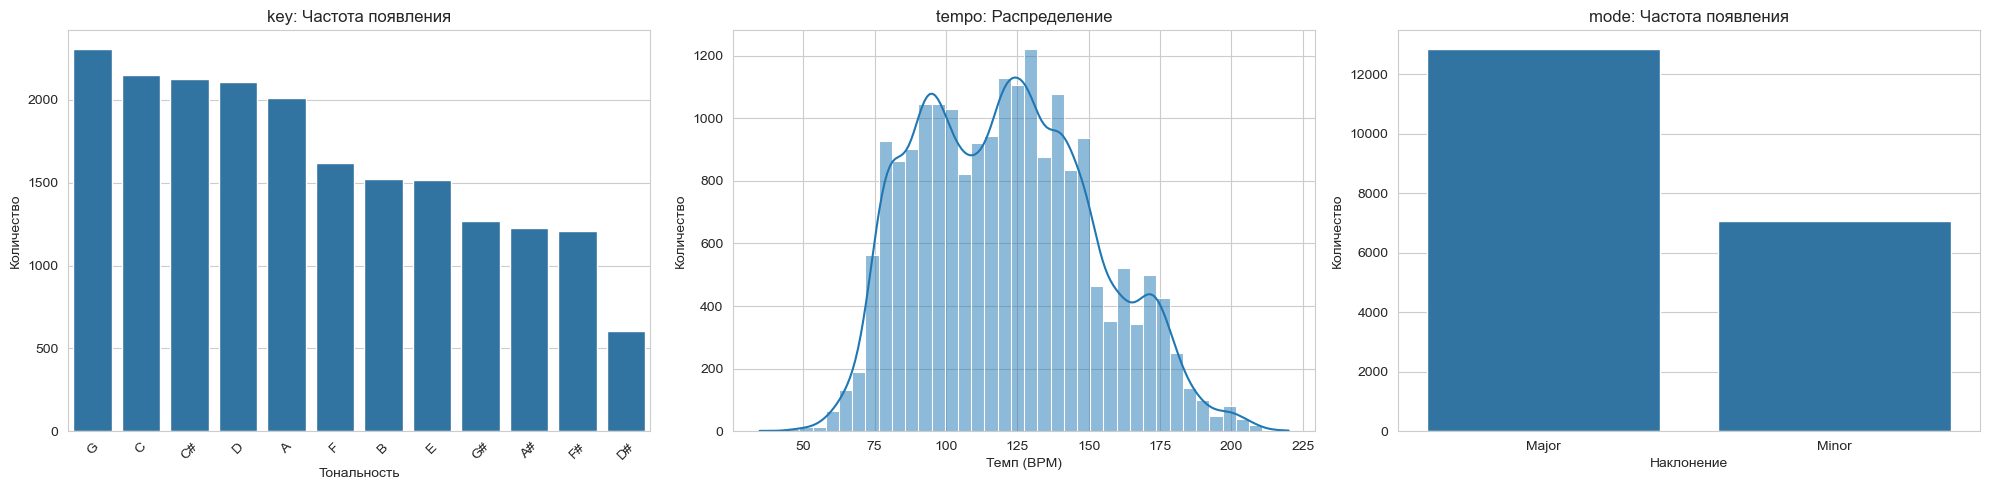

In [12]:
# Убираем пропуски
key_clean = train["key"].dropna()
tempo_clean = train["tempo"].dropna()
mode_clean = train["mode"].dropna()

# Преобразуем в строки (если нужно)
key_clean = key_clean.astype(str)
mode_clean = mode_clean.astype(str)

# Фигуры
fig, ax = plt.subplots(1, 3, figsize=(20, 5))

# key
sns.countplot(x=key_clean, ax=ax[0], order=key_clean.value_counts().index)
ax[0].set_title("key: Частота появления")
ax[0].set_xlabel("Тональность")
ax[0].set_ylabel("Количество")
ax[0].tick_params(axis='x', rotation=45)

# tempo
sns.histplot(tempo_clean, bins=40, kde=True, ax=ax[1])
ax[1].set_title("tempo: Распределение")
ax[1].set_xlabel("Темп (BPM)")
ax[1].set_ylabel("Количество")

# mode
sns.countplot(x=mode_clean, ax=ax[2], order=mode_clean.value_counts().index)
ax[2].set_title("mode: Частота появления")
ax[2].set_xlabel("Наклонение")
ax[2].set_ylabel("Количество")

plt.tight_layout()
plt.show();


## Разведочный анализ

In [13]:
# Создадим промежуточный датафрейм, с которым будем работать:

df_train = train.copy()

*Посмотрим на распределение целевой переменной*

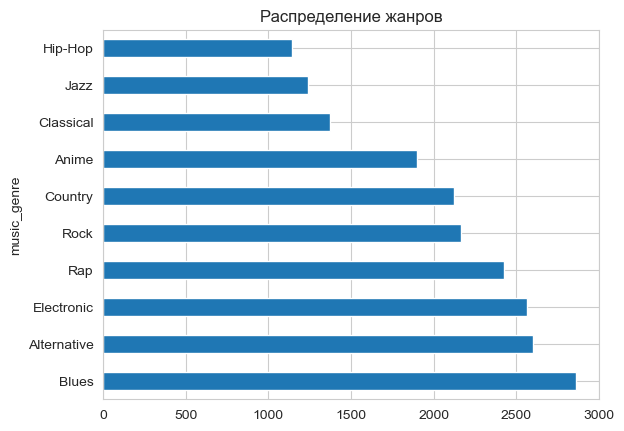

In [14]:
df_train["music_genre"].value_counts().plot(kind="barh", title="Распределение жанров");

*Видим, что у нас **умеренно несбалансированный** датасет. Нужно иметь это ввиду при обучении моделей

*Предобработаем датасет (уберем незначащие признаки ``instance_id``, ``track_name``, ``obtained_date`` и заполним пропуски*

In [15]:
# Удалим неинформативные признаки
df_train.drop(columns=["instance_id", "track_name", "obtained_date"], inplace=True)

# Посмотрим на количество пропусков
print(df_train.isnull().sum())

# Заполним пропуски:
# - числовой tempo — средним
# - категориальные key и mode — самым частым значением (модой)
df_train["tempo"] = df_train["tempo"].fillna(df_train["tempo"].mean())
df_train["key"] = df_train["key"].fillna(df_train["key"].mode()[0])
df_train["mode"] = df_train["mode"].fillna(df_train["mode"].mode()[0])

# Проверим снова
print("Пропуски после заполнения:\n", df_train.isnull().sum())


acousticness          0
danceability          0
duration_ms           0
energy                0
instrumentalness      0
key                 735
liveness              0
loudness              0
mode                506
speechiness           0
tempo               442
valence               0
music_genre           0
dtype: int64
Пропуски после заполнения:
 acousticness        0
danceability        0
duration_ms         0
energy              0
instrumentalness    0
key                 0
liveness            0
loudness            0
mode                0
speechiness         0
tempo               0
valence             0
music_genre         0
dtype: int64


### Построим ``pairplot`` и интерактивный дашборд с помощью ``pygwalker`` (html-файл)

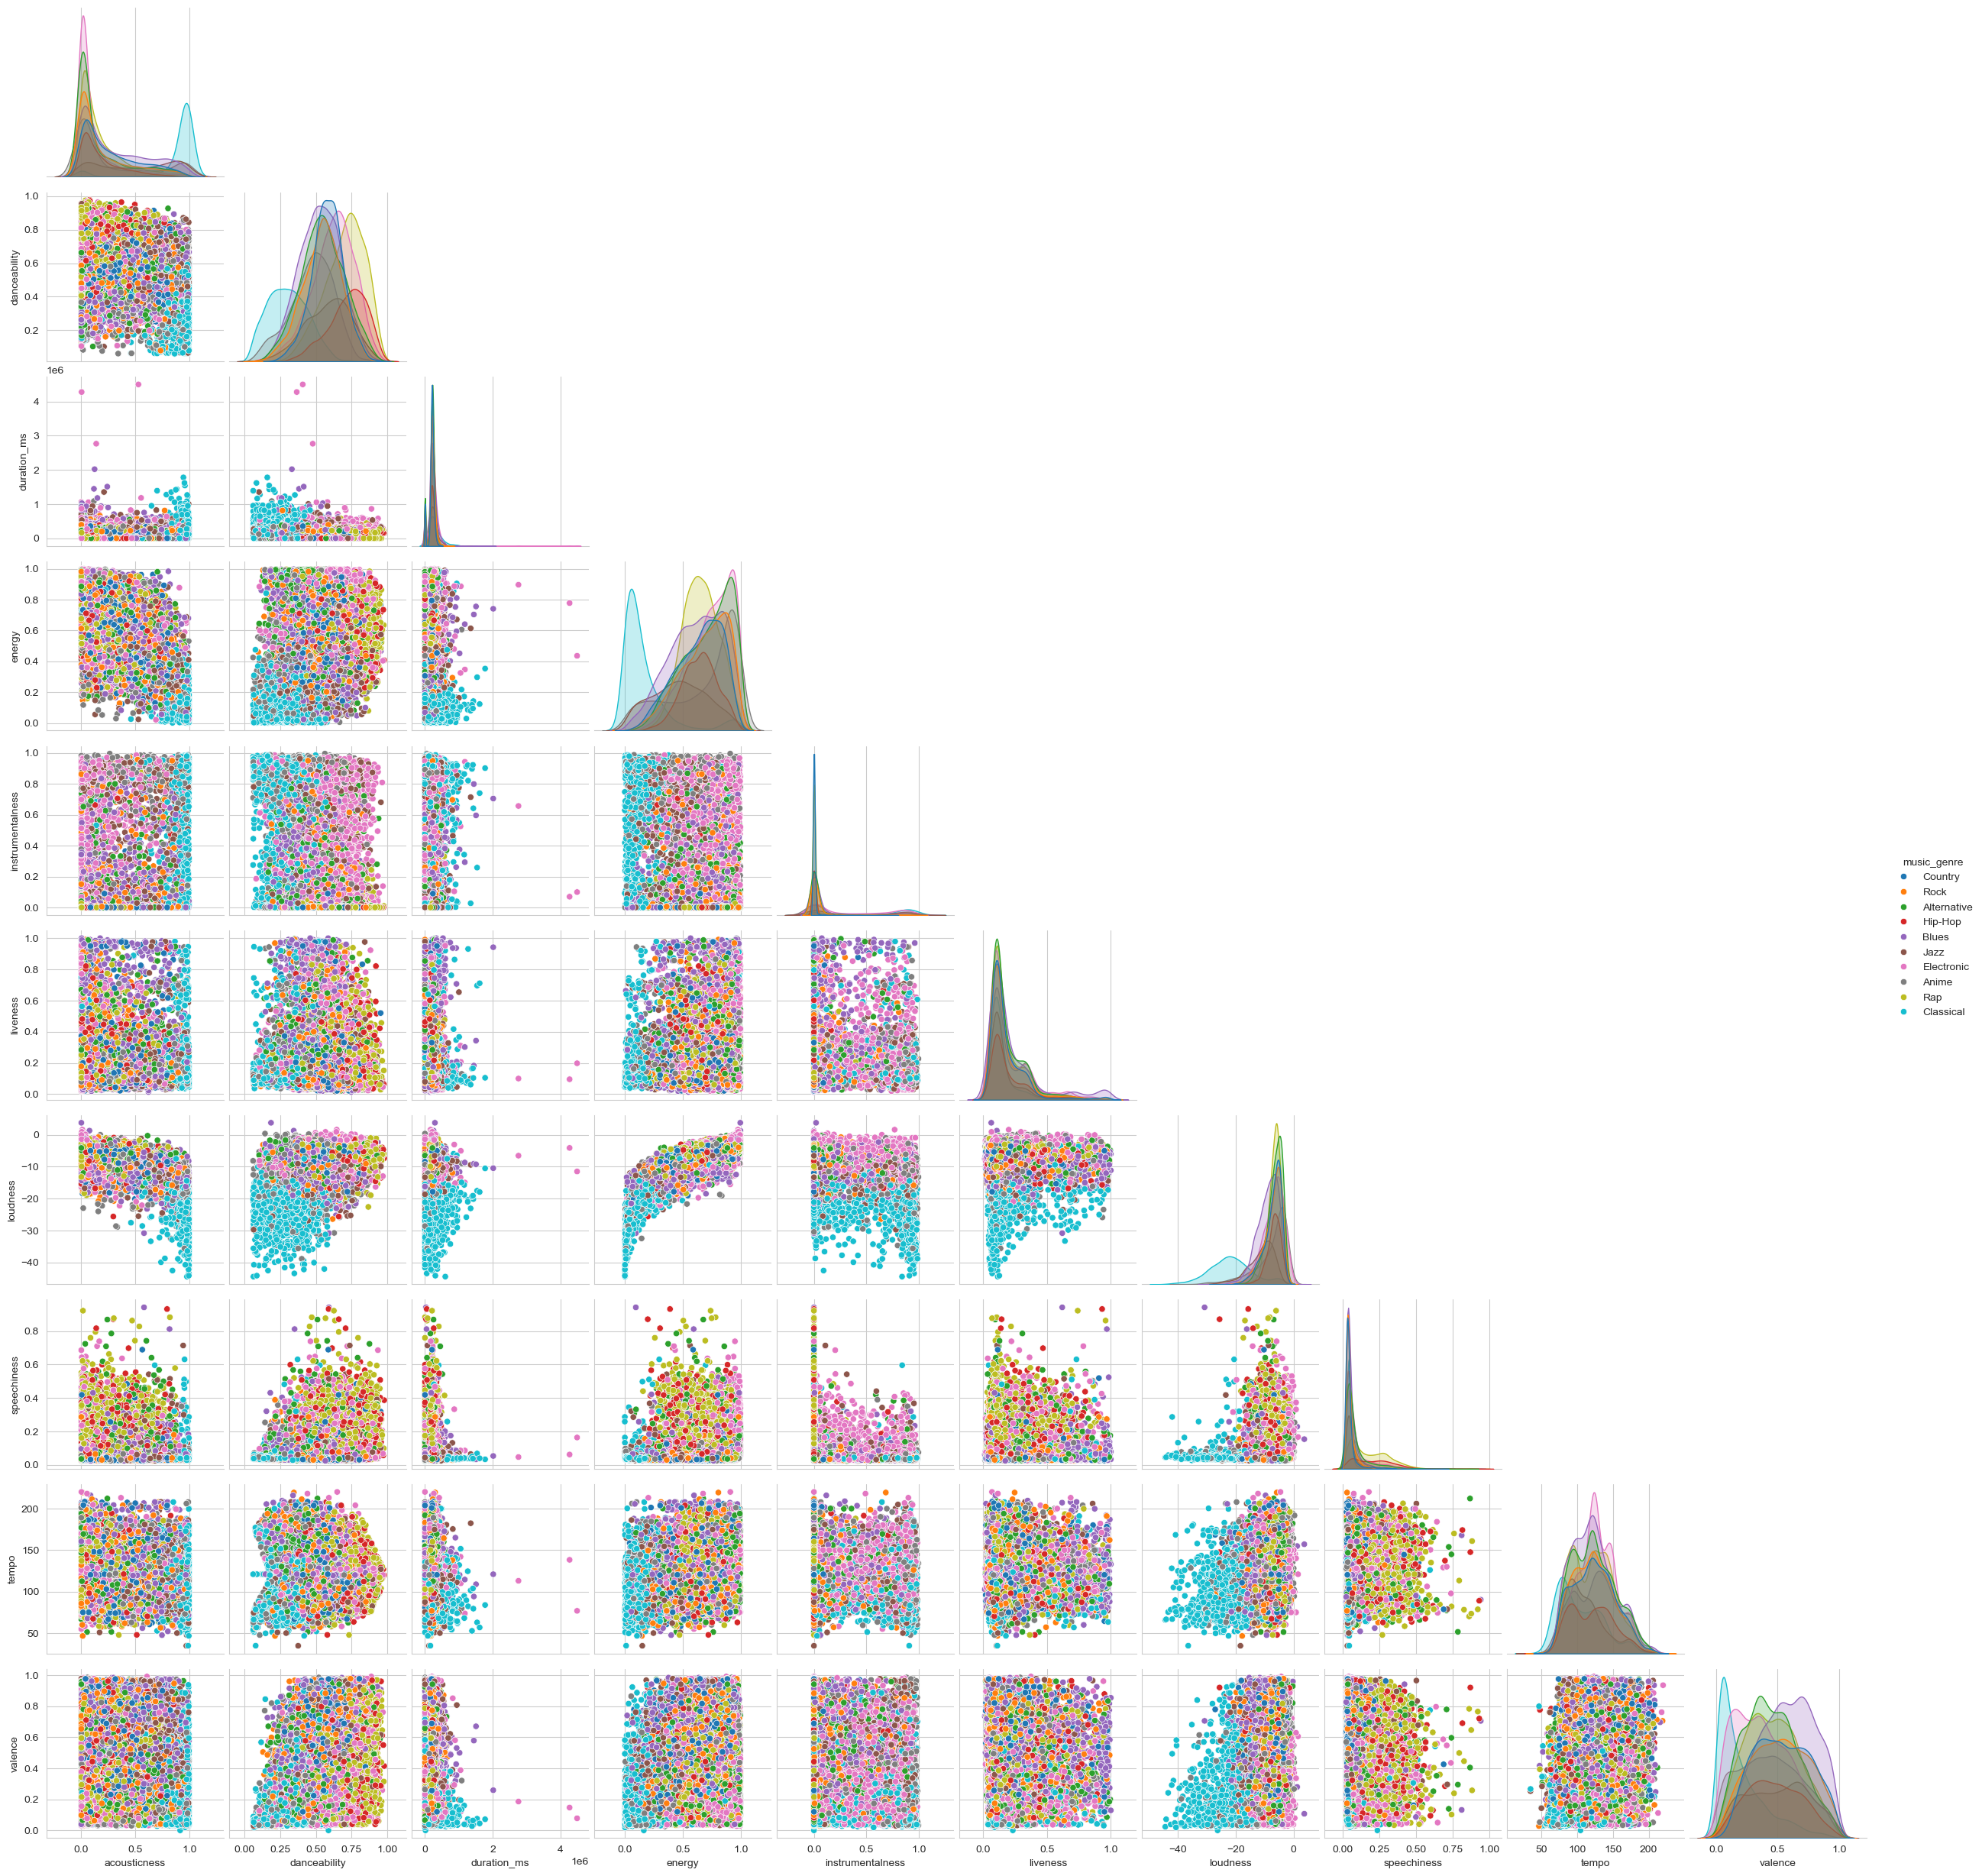

In [16]:
sns.pairplot(df_train, corner = True, hue = "music_genre");

In [17]:
# Также создадим дашборд (в html) и проанализируем некоторые данные в нем
# Это вспомогательный файл pyg_report.html, которым можно воспользоваться для оценки признаков в рамках интерактивного дашборда

with open("pyg_report.html", "w", encoding="utf-8") as f:
    f.write(pyg.to_html(df_train))


### Наблюдения:
* Классическая и электронная музыка, по многим параметрам, стоят на грачных значениях (т.е. максимально отличаются друг от друга).
* В электронной музыке наблюдаются выбросы по продолжительности. Это может стать хорошим критерием классификации (как правило, неэлектронные композиции не длятся по 1,5 часа)
* Кажется, что в некоторых показателях немало нулевых (или отрицательных) значений. Например ``duration = -1`` **2009** штук, ``instrumentalnes = 0`` **5978** штук
* Очевидно, что для показателя ``duration`` это выбросы или заглушки. Для ``instrumentalnes`` (в совокупности с показателем ``speechiness`` может быть признаком вокальных композиций без инструментала

In [18]:
# Посмотрим на статистики по датасету

df_train.describe().T

count           mean            std       min  \
acousticness      20394.0       0.274783       0.321643   0.00000   
danceability      20394.0       0.561983       0.171898   0.06000   
duration_ms       20394.0  220375.425272  126728.326142  -1.00000   
energy            20394.0       0.625276       0.251238   0.00101   
instrumentalness  20394.0       0.159989       0.306503   0.00000   
liveness          20394.0       0.198540       0.166742   0.01360   
loudness          20394.0      -8.552998       5.499917 -44.40600   
speechiness       20394.0       0.091352       0.097735   0.02230   
tempo             20394.0     120.942522      30.096038  34.76500   
valence           20394.0       0.464588       0.243387   0.00000   

                           25%            50%            75%          max  
acousticness           0.01520       0.120000       0.470000        0.996  
danceability           0.45100       0.570000       0.683000        0.978  
duration_ms       177517.00000  219533.000000  266000.000000  4497994.000  
energy                 0.47000       0.666000       0.830000        0.999  
instrumentalness       0.00000       0.000144       0.084475        0.996  
liveness               0.09730       0.130000       0.253000        1.000  
loudness             -10.25575      -7.052000      -5.054000        3.744  
speechiness            0.03560       0.049050       0.095575        0.942  
tempo                 96.02850     120.494000     140.974000      220.041  
valence                0.27200       0.457000       0.653000        0.992

**Взглянем отдельно на композиции с ``duration == -1``**

In [19]:
sns.pairplot(df_train[df_train.duration_ms == -1], corner = True, hue = "music_genre");

В целом картины схожие, т.е композиции с отсутствующей длительностью примерно равномерно распределены по выборке. Предлагается заменить значение ``-1`` медианой. На этапе обучения попробовать обучить модель с признаком и без него и сравнить результаты

In [20]:
# TRAIN: очищаем duration_ms
df_train.loc[df_train["duration_ms"] < 0, "duration_ms"] = np.nan
df_train["duration_ms"] = df_train["duration_ms"].fillna(train["duration_ms"].median())

# TEST: очищаем duration_ms
test.loc[test["duration_ms"] < 0, "duration_ms"] = np.nan
test["duration_ms"] = test["duration_ms"].fillna(train["duration_ms"].median())


## Работа с признаками

Разделим выборку df_train и построим модель на имеющихся данных:

In [21]:
catFeatures = ['key','mode'] #Выделим категориальные признаки

X_train, X_test, y_train, y_test = train_test_split(df_train.drop('music_genre', axis = 1), df_train.music_genre, test_size=TEST_SIZE, random_state=RANDOM_STATE)

Обучим CatBoostClassifier с базовыми настройками

In [22]:
model_0 = CatBoostClassifier(silent=True)
model_0.fit(X_train, y_train, cat_features=catFeatures)

In [23]:
y_tr_pred = model_0.predict(X_train)
y_ts_pred = model_0.predict(X_test)

f1_tr = f1_score(y_train, y_tr_pred, average='weighted')
f1_ts = f1_score(y_test, y_ts_pred, average='weighted')

print(f'F1-оценка для тренировочной выборки: {f1_tr:.3f}')
print(f'F1-оценка для тестовой выборки: {f1_ts:.3f}')

F1-оценка для тренировочной выборки: 0.719
F1-оценка для тестовой выборки: 0.461


***Модель переобучилась. Попробуем внести некоторые поправки для обучения***

In [24]:
model_01 = CatBoostClassifier(
    iterations = 300,
    depth=6,
    learning_rate = 0.05,
    l2_leaf_reg = 5,
    random_state = RANDOM_STATE,
    verbose=False
)

model_01.fit(X_train, y_train, cat_features=catFeatures)

y_tr_pred = model_01.predict(X_train)
y_ts_pred = model_01.predict(X_test)

f1_tr = f1_score(y_train, y_tr_pred, average='weighted')
f1_ts = f1_score(y_test, y_ts_pred, average='weighted')

print(f'F1-оценка для тренировочной выборки: {f1_tr:.3f}')
print(f'F1-оценка для тестовой выборки: {f1_ts:.3f}')

F1-оценка для тренировочной выборки: 0.488
F1-оценка для тестовой выборки: 0.451


* Переобучение практически ушло, раз

### Поработаем с отдельными признаками

In [25]:
df_train.columns #для удобства выведем список признаков

Index(['acousticness', 'danceability', 'duration_ms', 'energy',
       'instrumentalness', 'key', 'liveness', 'loudness', 'mode',
       'speechiness', 'tempo', 'valence', 'music_genre'],
      dtype='object')

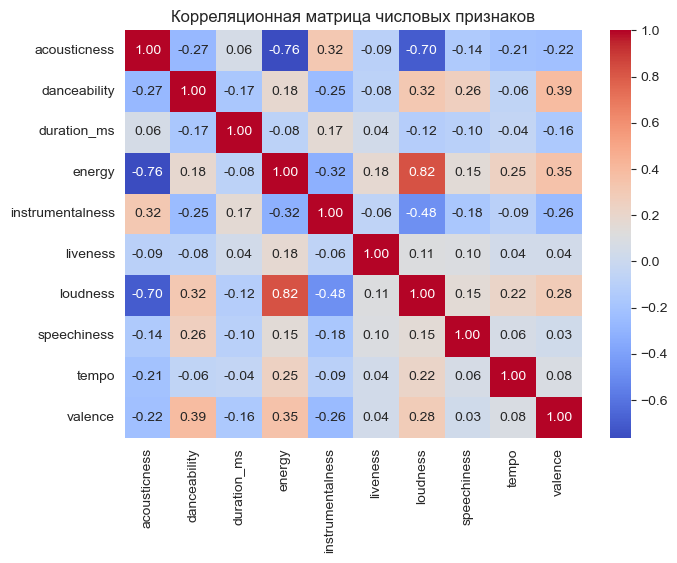

In [26]:
# Посмотрим на корреляции между численными признаками:
plt.title("Корреляционная матрица числовых признаков")
plt.tight_layout()
sns.heatmap(df_train.corr(numeric_only=True), annot=True, fmt=".2f", cmap="coolwarm");

#### Наблюдения:

* Признаки ``energy`` и ``loudness`` практически линейно зависимы (корреляция == 0.82). Один из них имеет смысл удалить. Для этого попробуем выстроить признаки по важности по ранее обученным моделям
* Признак ``acousticness`` имеет выраженную отрицательную корреляцию с ``energy`` и ``loudness``

Имеет смысл попробовать:

   * Создать синтетический признак из двух скоррелированных
   * Создать синтетический признаки на основе ``acousticness`` синтетических признаков

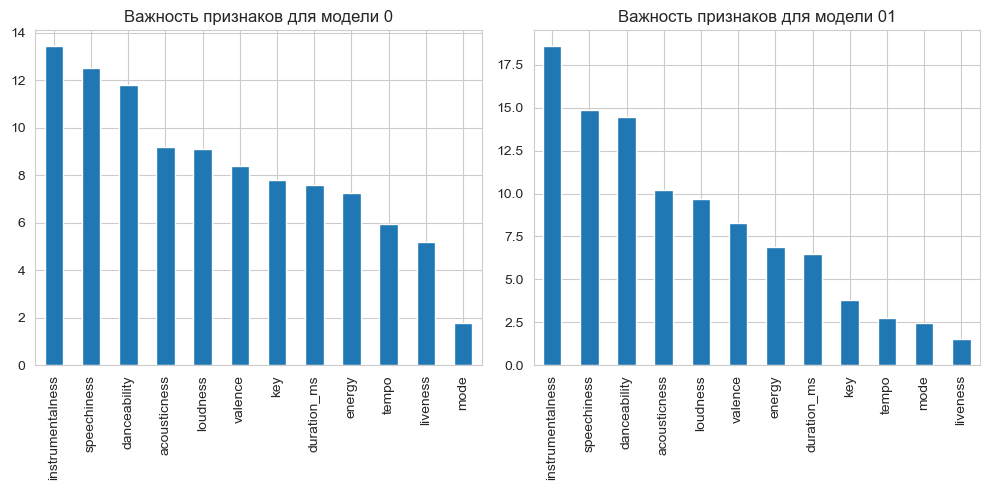

In [27]:
fig,ax = plt.subplots(1,2,figsize=(10, 5))
# fig.figsize = (20,0)

pd.Series(model_0.feature_importances_, index = X_train.columns).sort_values(ascending=False).plot(kind='bar',ax=ax[0])
ax[0].set_title("Важность признаков для модели 0")
pd.Series(model_01.feature_importances_, index = X_train.columns).sort_values(ascending=False).plot(kind='bar',ax=ax[1])
ax[1].set_title("Важность признаков для модели 01")
plt.tight_layout();

In [28]:
df_train.describe().T.loc[['loudness','energy', 'acousticness']]

count      mean       std       min       25%    50%    75%  \
loudness      20394.0 -8.552998  5.499917 -44.40600 -10.25575 -7.052 -5.054   
energy        20394.0  0.625276  0.251238   0.00101   0.47000  0.666  0.830   
acousticness  20394.0  0.274783  0.321643   0.00000   0.01520  0.120  0.470   

                max  
loudness      3.744  
energy        0.999  
acousticness  0.996

Обратим внимание как распределены признаки (``energy`` и ``acousticness``: **0-1**, ``loudness``: **-44.41 - 3.744**)

### Создадим синтетические признаки:

In [29]:
df_trainx = df_train.copy()

loud_z = (df_trainx["loudness"] - df_trainx["loudness"].mean()) / df_trainx["loudness"].std()
energy_z = (df_trainx["energy"] - df_trainx["energy"].mean()) / df_trainx["energy"].std()

df_trainx["loud_energy"] = df_train["loudness"] * df_train["energy"] # Произведение громкости и энергичночти
df_trainx["z_loud_minus_energy"] = loud_z - energy_z # Дельта нормированных показателей
df_trainx['duration_min'] = df_trainx['duration_ms'] / 60000 # Приведем показатель длительности к минутам


#### Оценим распределение числовых признаков

In [30]:
numeric_cols = df_trainx.select_dtypes(include='number').columns

n_cols = 3
n_rows = (len(numeric_cols) + n_cols - 1) // n_cols

plt.figure(figsize=(5 * n_cols, 4 * n_rows))

for i, col in enumerate(numeric_cols, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.kdeplot(data=df_trainx, x=df_trainx[col], hue='music_genre', fill=True)
    plt.title(f"{col}")

plt.tight_layout()
plt.show();

#### Попробуем еще раз обучить модель, с учетом новых признаков

F1-оценка для тренировочной выборки: 0.496
F1-оценка для тестовой выборки: 0.449


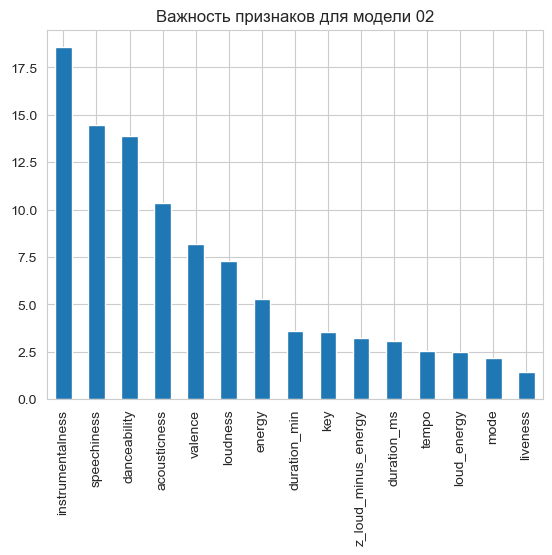

In [45]:
X_train, X_test, y_train, y_test = train_test_split(df_trainx.drop('music_genre', axis = 1), df_trainx.music_genre, test_size=TEST_SIZE, random_state=RANDOM_STATE)


model_02 = CatBoostClassifier(
    n_estimators = 300,
    depth=6,
    learning_rate = 0.05,
    l2_leaf_reg = 5,
    random_state = RANDOM_STATE,
    verbose=False
)

model_02.fit(X_train, y_train, cat_features=catFeatures, silent=True)

y_tr_pred = model_02.predict(X_train)
y_ts_pred = model_02.predict(X_test)

f1_tr = f1_score(y_train, y_tr_pred, average='weighted')
f1_ts = f1_score(y_test, y_ts_pred, average='weighted')

print(f'F1-оценка для тренировочной выборки: {f1_tr:.3f}')
print(f'F1-оценка для тестовой выборки: {f1_ts:.3f}')

plt.title("Важность признаков для модели 02")
pd.Series(model_02.feature_importances_, index = X_train.columns).sort_values(ascending=False).plot(kind='bar');


## Выбор и обучение моделей

Попробуем обучать модель убирая по одному признаки от наименее важного к наиболее важному.

In [60]:
# Пропишем функцию обучения модели и вывода результатов F1-оценки:

def model_fitter(df):
    """
    Функция принимает на вход pandas датафрейм, разделяет на обучающую и тестовую выборки и обучает на его базе CatboostClassifier с параметрами:
    n_estimators = 300,
    depth=6,
    learning_rate = 0.05,
    l2_leaf_reg = 5,
    random_state = RANDOM_STATE,
    verbose=0

    и возвращает F1-оценку для тренировочной и тестовой выборки
    """


    X_train, X_test, y_train, y_test = train_test_split(df.drop('music_genre', axis = 1), df.music_genre, test_size=TEST_SIZE,random_state=RANDOM_STATE)

    catFeatures = list(X_train.select_dtypes(exclude='number').columns)

    model = CatBoostClassifier(
    n_estimators = 300,
    depth=6,
    learning_rate = 0.05,
    l2_leaf_reg = 5,
    random_state = RANDOM_STATE,
    verbose=0
    )

    model.fit(X_train, y_train, cat_features=catFeatures)

    y_tr_pred = model.predict(X_train)
    y_ts_pred = model.predict(X_test)

    f1_tr = f1_score(y_train, y_tr_pred, average='weighted')
    f1_ts = f1_score(y_test, y_ts_pred, average='weighted')


    # print(f'F1-оценка для тренировочной выборки: {f1_tr:.3f}')
    # print(f'F1-оценка для тестовой выборки: {f1_ts:.3f}')
    return ','.join(list(X_train.columns)), f1_tr, f1_ts




In [61]:
feature_list=list(pd.Series(model_02.feature_importances_, index = X_train.columns).sort_values(ascending=True).index)[:-1] #не берем признак с максимальной значимостью
feature_to_drop = []
results = pd.DataFrame(columns = ['used_features', 'deleted_feature' ,'f1_train', 'f1_test'])

uf,f1tr,f1tst = model_fitter(df_trainx)
f = ''
results.loc[len(results)] = (uf,f,f1tr,f1tst) # добавим оценки для модели, обученной на всех признаках

for f in feature_list:
    feature_to_drop.append(f)
    uf,f1tr,f1tst = model_fitter(df_trainx.drop(feature_to_drop, axis=1))
    results.loc[len(results)] = uf,f,f1tr,f1tst

round(results,3)

used_features      deleted_feature  \
0   acousticness,danceability,duration_ms,energy,i...                        
1   acousticness,danceability,duration_ms,energy,i...             liveness   
2   acousticness,danceability,duration_ms,energy,i...                 mode   
3   acousticness,danceability,duration_ms,energy,i...          loud_energy   
4   acousticness,danceability,duration_ms,energy,i...                tempo   
5   acousticness,danceability,energy,instrumentaln...          duration_ms   
6   acousticness,danceability,energy,instrumentaln...  z_loud_minus_energy   
7   acousticness,danceability,energy,instrumentaln...                  key   
8   acousticness,danceability,energy,instrumentaln...         duration_min   
9   acousticness,danceability,instrumentalness,lou...               energy   
10  acousticness,danceability,instrumentalness,spe...             loudness   
11  acousticness,danceability,instrumentalness,spe...              valence   
12          danceability,instrumentalness,speechiness         acousticness   
13                       instrumentalness,speechiness         danceability   
14                                   instrumentalness          speechiness   

    f1_train  f1_test  
0      0.496    0.449  
1      0.492    0.448  
2      0.486    0.443  
3      0.484    0.446  
4      0.478    0.446  
5      0.477    0.441  
6      0.474    0.438  
7      0.488    0.444  
8      0.464    0.430  
9      0.457    0.425  
10     0.437    0.403  
11     0.401    0.376  
12     0.327    0.305  
13     0.263    0.260  
14     0.196    0.191

При удалении признаков по одному видим, что до шага №8 включительно эффект удаления небольшой, начиная с девятого качество начинает падать быстрее.

Попробуем выполнить обучение в обратном направлении, удаляя признаки по степени убывания их значимости.

In [62]:
feature_list=list(pd.Series(model_02.feature_importances_, index = X_train.columns).sort_values(ascending=False).index)[:-1] #не берем признак с максимальной значимостью
feature_to_drop = []
results = pd.DataFrame(columns = ['used_features', 'deleted_feature' ,'f1_train', 'f1_test'])

uf,f1tr,f1tst = model_fitter(df_trainx)
f = ''
results.loc[len(results)] = (uf,f,f1tr,f1tst) # добавим оценки для модели, обученной на всех признаках

for f in feature_list:
    feature_to_drop.append(f)
    uf,f1tr,f1tst = model_fitter(df_trainx.drop(feature_to_drop, axis=1))
    results.loc[len(results)] = uf,f,f1tr,f1tst

round(results,3)

used_features      deleted_feature  \
0   acousticness,danceability,duration_ms,energy,i...                        
1   acousticness,danceability,duration_ms,energy,k...     instrumentalness   
2   acousticness,danceability,duration_ms,energy,k...          speechiness   
3   acousticness,duration_ms,energy,key,liveness,l...         danceability   
4   duration_ms,energy,key,liveness,loudness,mode,...         acousticness   
5   duration_ms,energy,key,liveness,loudness,mode,...              valence   
6   duration_ms,energy,key,liveness,mode,tempo,lou...             loudness   
7   duration_ms,key,liveness,mode,tempo,loud_energ...               energy   
8   duration_ms,key,liveness,mode,tempo,loud_energ...         duration_min   
9   duration_ms,liveness,mode,tempo,loud_energy,z_...                  key   
10        duration_ms,liveness,mode,tempo,loud_energy  z_loud_minus_energy   
11                    liveness,mode,tempo,loud_energy          duration_ms   
12                          liveness,mode,loud_energy                tempo   
13                                      liveness,mode          loud_energy   
14                                           liveness                 mode   

    f1_train  f1_test  
0      0.496    0.449  
1      0.461    0.420  
2      0.434    0.395  
3      0.388    0.341  
4      0.360    0.324  
5      0.331    0.290  
6      0.331    0.290  
7      0.307    0.276  
8      0.306    0.272  
9      0.323    0.272  
10     0.289    0.247  
11     0.250    0.209  
12     0.224    0.191  
13     0.127    0.117  
14     0.119    0.101

Отберем признаки, которые выглядят значимыми, исходя из двух циклов выше. При этом обучим модель в двух вариантах: без категориальных признаков и с ними.

Числовые признаки, которые оставляем:
* Синтетический признак ``loud_energy``: во втором переборе отказ от признака ухудшает показатель оценки на 8-10 п.п.
* Признаки: ``valence``, ``acousticness``, ``danceability``, ``speechiness``, ``instrumentalness``

Также категориальные ``key`` и ``mode`` (при этом отметим, что удаление ``key`` в обоих случаях улучшает качество модели, попробуем обучить с ним и без него)


In [64]:
# Создадим новый датафрейм с отобранными признаками:
df_trainx_2 = df_trainx[['instrumentalness', 'speechiness', 'danceability', 'acousticness', 'valence', 'loud_energy', 'key', 'mode', 'music_genre']]

df_trainx_2.head()

instrumentalness  speechiness  danceability  acousticness  valence  \
0          0.017600       0.0463         0.670        0.4800    0.450   
1          0.000051       0.0352         0.452        0.2430    0.539   
2          0.000000       0.3710         0.454        0.2280    0.344   
3          0.000003       0.0804         0.847        0.0558    0.966   
4          0.000002       0.0487         0.742        0.2270    0.583   

   loud_energy key   mode  music_genre  
0    -5.911542   D  Major      Country  
1    -5.622640   A  Minor         Rock  
2    -4.200900   E  Minor  Alternative  
3    -4.194765  G#  Minor      Hip-Hop  
4    -3.191250   C  Major  Alternative

Обучим модель с различными комбинациями признаков:

In [ ]:
from itertools import combinations

synthetic_results = pd.DataFrame(columns=["feature_combo", "operation", "f1_train", "f1_test"])
epsilon = 1e-6

top_features = ['instrumentalness', 'speechiness', 'danceability', 'acousticness', 'valence', 'loud_energy']

for f1, f2 in combinations(top_features, 2):
    for op in ['+', '-', '*', '/']:
        df_temp = df_trainx_2.copy()
        new_col = f"{f1}_{op}_{f2}"

        if op == '+':
            df_temp[new_col] = df_temp[f1] + df_temp[f2]
        elif op == '-':
            df_temp[new_col] = df_temp[f1] - df_temp[f2]
        elif op == '*':
            df_temp[new_col] = df_temp[f1] * df_temp[f2]
        elif op == '/':
            df_temp[new_col] = df_temp[f1] / (df_temp[f2] + epsilon)

        _,  f1_tr, f1_ts = model_fitter(df_temp)
        synthetic_results.loc[len(synthetic_results)] = [f"{f1} {op} {f2}", op, f1_tr, f1_ts]


In [69]:
print(synthetic_results)

                      feature_combo operation  f1_train   f1_test
0    instrumentalness + speechiness         +  0.443220  0.419637
1    instrumentalness - speechiness         -  0.439958  0.417236
2    instrumentalness * speechiness         *  0.442865  0.417132
3    instrumentalness / speechiness         /  0.442441  0.419728
4   instrumentalness + danceability         +  0.443282  0.415861
5   instrumentalness - danceability         -  0.444792  0.418088
6   instrumentalness * danceability         *  0.443908  0.419049
7   instrumentalness / danceability         /  0.444407  0.416417
8   instrumentalness + acousticness         +  0.442948  0.419371
9   instrumentalness - acousticness         -  0.441628  0.416293
10  instrumentalness * acousticness         *  0.443450  0.421647
11  instrumentalness / acousticness         /  0.442077  0.416515
12       instrumentalness + valence         +  0.442079  0.419319
13       instrumentalness - valence         -  0.443557  0.413464
14       i

## Оценка качества

## Анализ важности признаков модели